# DU Level 1: Harnessing Big Data to Decode Changes in Transcription

## **📌 Introduction: Multi-Omics Data Integration for Understanding Transcriptional Regulation**  

### **🔎 Background**  
Advances in **multi-omics data integration** have transformed how we study complex biological systems, allowing us to combine different types of **large-scale datasets** that measure distinct biological layers—such as **genomics, transcriptomics, proteomics, and epigenomics**—to gain a more holistic view of cellular processes.  

Here, we focus on **transcription**, the process by which genes are converted into RNA. This process is tightly regulated by **transcription factors (TFs)**—proteins that can activate or repress the transcription of **hundreds of genes**. When mutations occur in these TFs, or in the proteins they interact with, the **downstream effects can be widespread**, leading to **global shifts in gene expression** that alter cellular function.  

By integrating **multi-omics datasets**, we can systematically analyze how **mutations impact TF functioning** and how these disruptions shape the transcriptional landscape. This requires assembling different **biological puzzle pieces**—such as **genomic mutations, 3D structural information, and transcriptional outputs**—to reconstruct the regulatory networks that impair these cellular processes.  

### **🚀 Why This Matters**  
By applying **computational tools and machine learning**, we can:  
✔ **Identify mutations that alter TF activity** and their impact on gene expression.  
✔ **Map regulatory networks** connecting genetic changes to transcriptional shifts.  
✔ **Prioritize key molecular drivers** of disease that may serve as potential drug targets.  

In this workflow, we will explore how **multi-omics integration** can be used to uncover **transcriptional regulation dynamics** and their biochemical consequences, helping to bridge the gap between genomic alterations and their functional effects in cancer.  

### **🚀 What is Multi-omics Data?**  
Big multi-omics data refers to vast, complex datasets that are too large for traditional methods to process efficiently. In cancer research, this data includes genomic sequencing, transcriptomic profiles, and structural variations across thousands of cancer cell lines.

Cancer cell lines—populations of tumor-derived cells that can be cultured indefinitely—serve as powerful models for studying how mutations reshape gene expression. Each cell line carries distinct genetic alterations that influence transcription, the process by which genes are converted into RNA. These transcriptional shifts can activate certain genes, silence others, and rewire cellular pathways, ultimately driving changes in whole cell phenotypes.

By integrating computational tools like Python, we can systematically analyze these large-scale datasets to uncover fundamental biochemical relationships between genetic mutations and transcriptional changes. 


## Setting Up the Environment & Import Data

In [1]:
# Using IPython.display, we can modify the appearance of the Jupyter Notebook layout to better fit the content on the screen.

#This snippet adjusts the width of the notebook container, menu bar, and toolbar for a better viewing experience.

from IPython.display import clear_output
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

# Import necessary libraries

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import py3Dmol

pd.set_option('display.max_columns', None)  # show all columns
pd.set_option('display.max_rows', None)

from mmtfPyspark.datasets import pdbToUniProt

## Leveraging Large-scale Cancer Data for Fundamental Insights

The Cancer Dependency Map (DepMap) and the Cancer Cell Line Encyclopedia (CCLE) are two of the most powerful multi-omic data resources in cancer research. They provide large-scale genomic and functional datasets that help scientists understand how genetic changes drive changes in biochemical pathways and which genes are essential for cell survival.

🏛 What is DepMap / CCLE?
CCLE (Cancer Cell Line Encyclopedia) was launched in 2012 as a collaborative effort between the Broad Institute, Dana-Farber Cancer Institute, and other research groups. It provides detailed genomic, transcriptomic, and proteomic profiles of ~2,000 cancer cell lines across different tissues.
DepMap (Cancer Dependency Map) expands upon CCLE by systematically identifying which genes are essential for cancer cell survival using large-scale CRISPR knockout screens. The goal is to map out genetic dependencies in cancer, revealing vulnerabilities that could be targeted for new therapies.

🚀 Why is DepMap Important?
Cancer is a highly complex disease driven by mutations, gene copy number variations (CNVs), epigenetic changes, and transcriptional shifts. Understanding which genes are drivers of cancer versus which are passenger mutations is critical for developing more effective treatments.

📌 **DepMap helps researchers by:**  
&nbsp;&nbsp;&nbsp;&nbsp;   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;✅ Identifying cancer vulnerabilities – genes that cancer cells depend on for survival  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;✅ Connecting mutations, CNVs, and gene expression to drug sensitivity and resistance  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;✅ Providing a large-scale dataset to study fundamental biochemical relationships between genes, their mutations, and their transcriptional regulation  

🔬 **How can we use CCLE / DepMap**  
&nbsp;&nbsp;&nbsp;&nbsp; With computational tools like Python, we can analyze DepMap datasets to explore:  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;➡ How mutations affect gene expression  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;➡ Which proteins regulate key processes, like transcription  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;➡ Which proteins, when mutated, impact transcriptional regulation


By leveraging DepMap, we can uncover key biological insights and fundamental understanding of these key biochemical concepts on a global scale.

**Important**: Please download the following CCLE data files before loading into Jupyter: 

https://drive.google.com/file/d/183seE2_moIIc2_QC4E-6UxEzU9I1farO/view?usp=drive_link

https://drive.google.com/file/d/1_TdjzbVHSHgDuKEv7qPoc_Hn9kdOBSaa/view?usp=sharing

You will need to **unzip** these files before uploading them to Cyverse or loading them into this notebook. 

In [2]:

# 📂 Load Sample Info File  
print("Loading sample information...")
samples = pd.read_csv("sample_info.csv")

# Keep only relevant columns (ID and Name)
ccle = samples[['DepMap_ID', 'CCLE_Name','primary_disease']]
print(f"✅ Loaded {len(samples)} cell lines from sample_info.csv")

# 🧬 Load Mutation Data  
print("Loading mutation data...")
mut = pd.read_csv("CCLE_mutations.csv")

# Rename the first column to 'DepMap_ID' for consistency
mut.rename(columns={'Unnamed: 0': 'DepMap_ID'}, inplace=True)

# Merge CNV data with sample info to include cell line names
mut = ccle.merge(mut[['DepMap_ID','Hugo_Symbol','Genome_Change','Chromosome','Protein_Change','Variant_Classification','Variant_Type','Variant_annotation']], on='DepMap_ID')

# Standardize column names (extract HUGO gene symbols)
mut.columns = [col.split(' ')[0] for col in mut.columns]
print(f"✅ Mutation data contains {len(mut.Hugo_Symbol.unique())} genes for {len(mut.CCLE_Name.unique())} cell lines")

# 🧬 Load Gene Expression Data  
print("Loading gene expression data...")
ge = pd.read_csv("CCLE_expression.csv")

# Rename the first column to 'DepMap_ID' for consistency
ge.rename(columns={'Unnamed: 0': 'DepMap_ID'}, inplace=True)

# Standardize column names (extract HUGO gene symbols)
ge.columns = [col.split(' ')[0] for col in ge.columns]

# Merge gene expression data with sample info
ge = ccle.merge(ge, on='DepMap_ID')
print(f"✅ Gene expression data contains {ge.shape[1]-2} genes for {ge.shape[0]} cell lines")

# 🏁 Done!
print("✅ Data successfully loaded and merged!")


Loading sample information...
✅ Loaded 1829 cell lines from sample_info.csv
Loading mutation data...


/opt/conda/envs/mmtf-pyspark/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3257: DtypeWarning: Columns (3,19,22,27,28,29,30,31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


✅ Mutation data contains 19537 genes for 1759 cell lines
Loading gene expression data...
✅ Gene expression data contains 19222 genes for 1394 cell lines
✅ Data successfully loaded and merged!


# Exploring the Human Genome with UCSC Genome Browser Data

The UCSC Genome Browser is a powerful tool that provides access to a wealth of genomic information, including gene annotations, sequence variations, and structural features of the human reference genome. This browser allows researchers to explore how genes are organized, where mutations occur, and how genomic elements interact to regulate transcription.

In this lesson, we will work with genome.csv, a dataset downloaded from the UCSC Genome Browser. This file contains detailed annotations of the human genome, including information on genes, chromosomal locations, exon-intron structures, and other genomic features. By analyzing this dataset, we can investigate how mutations, copy number variations (CNVs), and gene locations influence transcription and disease progression.

🔗 Useful UCSC Genome Browser Links
UCSC Genome Browser: https://genome.ucsc.edu/
Downloads & Public Data: http://hgdownload.soe.ucsc.edu/downloads.html
Table Browser (for custom dataset queries): https://genome.ucsc.edu/cgi-bin/hgTables
We'll start by reading in genome.csv and exploring its structure before using Python to extract meaningful insights from the data.

In [3]:
# gene to UniProtId mapping
genome = pd.read_csv('genome.csv')

# Ensure 'uniprot_ids' is correctly referenced
genome = genome[(pd.notna(genome['uniprot_ids']))][['symbol', 'uniprot_ids']]

# Rename the column properly
genome.rename(columns={'uniprot_ids': 'uniprotId'}, inplace=True)
genome.rename(columns={'symbol': 'Gene'}, inplace=True)


# Check if the column rename worked
print(genome.head(2))

      Gene uniprotId
8    OR4F5    Q8NH21
17  OR4F29    Q6IEY1


/opt/conda/envs/mmtf-pyspark/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3257: DtypeWarning: Columns (39) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## **📌 Exploring Single Nucleotide Mutations (SNVs) and Their Impact on Gene Expression**  

To understand how **single nucleotide mutations (SNVs) affect gene expression (RNA levels)**, we first need to import data from **DepMap**. The datasets we are using provide information on cancer cell lines, their **genetic mutations**, and **transcriptional changes**.  

---

### 📂 **Understanding the Sample Info File (`sample_info.csv`)**  
The **`sample_info.csv`** file contains detailed information about each cancer cell line, including:  
- 🏷 **Cell line name** (e.g., *A549, MCF7*)  
- 🏥 **Tissue of origin** (e.g., lung, breast, colon)  
- 🔬 **Cancer type** (e.g., non-small cell lung cancer, triple-negative breast cancer)  
- 👤 **Patient background** (where applicable)  

We primarily use the **cell line name (`CCLE_Name`)** from this file to map **mutation** and **RNA expression** data.

---

### 🧬 **What is a Single Nucleotide Mutation (SNV)?**  
A **single nucleotide mutation** (also called a **single nucleotide variant (SNV)** or **point mutation**) occurs when **one DNA base (A, T, C, or G) is altered**. If this mutation occurs in a **protein-coding gene**, it can change the **codon sequence**, potentially leading to a different **amino acid** in the resulting protein.  

#### 🔗 **Why Are SNVs Important in Cancer?**  
✔ **Missense mutations** → A single base change results in a **different amino acid**, potentially altering protein function.  
✔ **Nonsense mutations** → A mutation introduces a **premature stop codon**, leading to an incomplete (nonfunctional) protein.  
✔ **Silent mutations** → A mutation does **not** change the amino acid but might still affect gene regulation.  
✔ **Splice site mutations** → A mutation disrupts **RNA splicing**, potentially removing or adding exons incorrectly.  
✔ **Regulatory region mutations** → A mutation in a **promoter or enhancer** region can impact **how much RNA is transcribed**.  

---

### 📝 **How SNVs Affect RNA Expression**  
Even a **single base change** can have significant effects on gene expression by:  

📈 **Increasing transcription** → If the mutation activates an oncogene or enhances promoter activity.  
📉 **Decreasing transcription** → If the mutation disrupts transcription factor binding or enhancer function.  
🚫 **Disrupting RNA splicing** → Leading to improperly formed mRNA.  
💀 **Producing nonfunctional proteins** → If a nonsense mutation leads to an early stop codon.  

By linking **mutation data with gene expression data**, we can explore how **genetic alterations drive transcriptional changes in cancer**.  

---

### **🔍 What We Will Explore in This Workflow**  
In this workflow, we will analyze:  
✔ **Which genes have frequent mutations in cancer cell lines?**  
✔ **How do mutations in key transcription factors impact their target gene expression?**  
✔ **Are there patterns linking mutations to increased or decreased RNA expression?**  

🚀 Now, let’s load our datasets and begin analyzing these relationships!  


In [4]:
# 🔍 Identify metadata columns that should NOT be melted
non_gene_cols = {'DepMap_ID', 'CCLE_Name', 'primary_disease'}

# 🔍 Mutation-related columns to keep
mutation_info_cols = ['Genome_Change', 'Protein_Change', 'Variant_Classification', 
                      'Variant_Type', 'Variant_annotation']

# Ensure only relevant columns are included
mut_selected_cols = ['DepMap_ID', 'CCLE_Name', 'Hugo_Symbol'] + mutation_info_cols  # Keep all key mutation info

# 🛠 Keep mutations intact while structuring correctly  
print("🔄 Formatting Mutation data...")
mut_melted = mut[mut_selected_cols].rename(columns={'Hugo_Symbol': 'Gene'})  # Align column names
print(f"✅ Mutation data formatted: {mut_melted.shape[0]:,} rows.")

# 🔄 Transform Gene Expression DataFrame  
print("🔄 Transforming Gene Expression data into long format...")
gene_cols_ge = [col for col in ge.columns if col not in non_gene_cols]
ge_melted = pd.melt(ge, id_vars=['DepMap_ID', 'CCLE_Name'], value_vars=gene_cols_ge, var_name='Gene', value_name='GE')
print(f"✅ Gene Expression data transformed: {ge_melted.shape[0]:,} rows.")

# 🔗 Merge Mutation and Gene Expression Data  
print("🔗 Merging Mutation and Gene Expression data...")
DF = pd.merge(mut_melted, ge_melted, on=['DepMap_ID', 'CCLE_Name', 'Gene'], how='left')
print(f"✅ Merged dataset created: {DF.shape[0]:,} rows.")

# 🔗 Merge with primary disease info  
print("🔗 Adding primary disease information...")
DF = DF.merge(ccle[['DepMap_ID', 'primary_disease']], on='DepMap_ID', how='left')
print(f"✅ Added primary disease information.")

# 🔗 Merge with UniProtId info  
print("🔗 Adding UniProtId information...")
DF = DF.merge(genome, on='Gene', how='left')
print(f"✅ Added UniProtId information.")

# 🧹 Remove rows with missing values  
print("🧹 Dropping missing values...")
DF.dropna(inplace=True)
print(f"✅ Cleaned dataset: {DF.shape[0]:,} rows after removing missing values.")

# 📊 Summary of the dataset  
print("\n📌 **Final Dataset Summary:**")
print(f"   🧪 {DF['CCLE_Name'].nunique()} unique cancer cell lines in common.")
print(f"   🧬 {DF['Gene'].nunique()} unique genes in common.")

# 🔍 Preview the first 2 rows  
print("\n🔍 **Preview of the merged dataset:**")
display(DF.head(2))  # Display nicely in Jupyter Notebook


🔄 Formatting Mutation data...
✅ Mutation data formatted: 1,231,281 rows.
🔄 Transforming Gene Expression data into long format...
✅ Gene Expression data transformed: 26,794,074 rows.
🔗 Merging Mutation and Gene Expression data...
✅ Merged dataset created: 1,231,281 rows.
🔗 Adding primary disease information...
✅ Added primary disease information.
🔗 Adding UniProtId information...
✅ Added UniProtId information.
🧹 Dropping missing values...
✅ Cleaned dataset: 1,045,284 rows after removing missing values.

📌 **Final Dataset Summary:**
   🧪 1388 unique cancer cell lines in common.
   🧬 17448 unique genes in common.

🔍 **Preview of the merged dataset:**


,DepMap_ID,CCLE_Name,Gene,Genome_Change,Protein_Change,Variant_Classification,Variant_Type,Variant_annotation,GE,primary_disease,uniprotId
0,ACH-000001,NIHOVCAR3_OVARY,VPS13D,g.chr1:12359347C>A,p.S2041*,Nonsense_Mutation,SNP,damaging,4.454176,Ovarian Cancer,Q5THJ4
1,ACH-000001,NIHOVCAR3_OVARY,AADACL4,g.chr1:12726308_12726322delCTGGCGTGACGCCAT,p.WRDAI263del,In_Frame_Del,DEL,other non-conserving,0.000000,Ovarian Cancer,Q5VUY2


## 📌 Filtering for Missense Mutations & Exploring Their Distribution  

### 🔎 Background  
Single nucleotide variants (SNVs) can impact protein function, but only some of these mutations **change the amino acid sequence**. These are called **missense mutations** and can alter protein structure, stability, and interactions.  

In this section, we will **filter the dataset to include only missense mutations** and then analyze:  
✔ **How many missense mutations are present in the dataset**  
✔ **How many unique genes have at least one missense mutation**  
✔ **How many cell lines contain at least one missense mutation**  

---

## 📝 Your Tasks  

1️⃣ **Filter the dataset** to keep only mutations classified as `"Missense_Mutation"`.  
2️⃣ **Count the number of unique missense mutations** in the dataset.  
3️⃣ **Determine how many unique genes contain at least one missense mutation.**  
4️⃣ **Determine how many unique cell lines contain at least one missense mutation.**  
5️⃣ **Interpret your results:**  
   - Are missense mutations common across many genes, or concentrated in a few?  
   - Are certain cell lines more prone to missense mutations?  

In [5]:
# 🔍 Step 1: Filter for Missense Mutations
DF_missense = DF[DF['Variant_Classification'] == 'Missense_Mutation']

# 📊 Step 2: Count total number of missense mutations
total_missense_mutations = DF_missense.shape[0]

# 🔬 Step 3: Count unique genes with missense mutations
unique_genes = DF_missense['Gene'].nunique()

# 🧬 Step 4: Count unique cell lines with at least one missense mutation
unique_cell_lines = DF_missense['CCLE_Name'].nunique()

# 📢 Print Summary
print(f"✅ Total Missense Mutations: {total_missense_mutations:,}")
print(f"✅ Unique Genes with Missense Mutations: {unique_genes:,}")
print(f"✅ Unique Cell Lines with Missense Mutations: {unique_cell_lines:,}")

✅ Total Missense Mutations: 613,369
✅ Unique Genes with Missense Mutations: 17,385
✅ Unique Cell Lines with Missense Mutations: 1,388


## Exploring Mutation Effects on the NRF2 Transcriptional Activities

## **📌 Introduction: NRF2 and Its Role in Cellular Stress Response & Metabolism**  

### **🔎 Background**  
NRF2 (Nuclear Factor Erythroid 2-Related Factor 2) is a **master transcription factor** that regulates cellular responses to **oxidative stress** and plays a critical role in **metabolism, detoxification, and redox homeostasis**. Under normal conditions, NRF2 levels are kept **low** in the cell through a tightly controlled **degradation system** to prevent unnecessary activation.  

NRF2 is degraded through the **ubiquitin-proteasome system**, where specialized **E3 ligases** recognize and tag proteins for degradation. Two key degradation regulators of NRF2 are:  
✔ **KEAP1 (Kelch-like ECH-Associated Protein 1)** → Directly binds NRF2 and recruits the degradation machinery.  
✔ **CUL3 (Cullin 3)** → Part of the **E3 ligase complex** that facilitates NRF2 ubiquitination, leading to its degradation.  

### **🔬 NRF2 Activation Under Stress**  
When the cell detects **stress signals**—such as oxidative stress caused by **reactive oxygen species (ROS), toxic compounds, or metabolic imbalance**—NRF2 degradation is **turned off**, allowing NRF2 levels to rise. This enables NRF2 to **enter the nucleus** and activate genes involved in:  
✔ **Antioxidant defense** (e.g., glutathione synthesis)  
✔ **Detoxification pathways** (e.g., phase I & II metabolism)  
✔ **Metabolic reprogramming** (e.g., glycolysis and lipid metabolism)  

### **🚀 Why This Matters**  
Mutations in **KEAP1, CUL3, or NRF2 itself** can disrupt this regulatory balance, leading to **abnormal NRF2 activity**. In some cancers, **loss of KEAP1 or CUL3 function** results in **persistent NRF2 activation**, which enhances cell survival, alters metabolism, and promotes drug resistance.  

### **🔍 What We Will Explore in This Workflow**  
In this workflow, we will investigate **how mutations in KEAP1, CUL3, and NRF2 affect NRF2 transcriptional activity** by integrating **genomic, transcriptomic, and proteomic data**. This will allow us to determine:  
✔ When and where NRF2 is overactive due to disrupted degradation.  
✔ The downstream metabolic consequences of NRF2 dysregulation.  
✔ How multi-omics approaches can reveal key regulatory mechanisms.  


## 🔗 Introduction to STRING Database: Exploring Protein-Protein Interactions  

### 🔎 What is STRING?  
STRING (**Search Tool for the Retrieval of Interacting Genes/Proteins**) is a **database of known and predicted protein-protein interactions**. These interactions are derived from:  
✔ **Experimental data** (e.g., co-immunoprecipitation, yeast two-hybrid screens)  
✔ **Computational predictions**  
✔ **Text mining from scientific literature**  
✔ **Co-expression and genomic context analysis**  

By integrating **multi-source biological data**, STRING helps researchers understand **how proteins work together** in biological pathways.

### 🌍 Access STRING Database  
To explore **NRF2 (NFE2L2) interactions**, visit:  
🔗 **[STRING Database](https://string-db.org/)**  

### 🔬 Finding NRF2-Interacting Proteins  
1️⃣ **Go to** [STRING-db.org](https://string-db.org/)  
2️⃣ In the **search bar**, type:  
   - `"NRF2"` *or*  
   - `"NFE2L2"` (the official gene name for NRF2)  
3️⃣ Click **Search** and select **Homo sapiens (human)**.  

You will now see a **network of proteins that STRING predicts to interact with NRF2**, ranked by confidence scores. These interactions may represent:  
- **Direct physical interactions** (binding partners)  
- **Functional associations** (regulatory interactions, metabolic pathways, co-expression)  

### 📥 Exporting STRING Data  
1️⃣ Click on the **"Export"** button (top right of the results page).  
2️⃣ Under **File Format**, select:  
   - 📝 **"TSV: Tab-Separated Values - Can be Opened in Excel (Lists Reciprocal Edges: A-B, B-A)"**  
3️⃣ Download and save the file as **`string_interactions.tsv`**.  

### 🚀 **Try it Yourself!**  
🔍 **Download STRING interaction data for NRF2 (NFE2L2)** and open it in **Excel** or **Python**.  
🔬 **Examine the list of interacting proteins** – which proteins have the strongest predicted interactions?  

---


In [6]:
# Load the STRING interactions dataset
NRF2_interactions = pd.read_table('string_interactions_short.tsv')

# Sort by combined_score in descending order
NRF2_interactions = NRF2_interactions.sort_values(by='combined_score', ascending=False)

# Display the top rows
NRF2_interactions.head()


,#node1,node2,node1_string_id,node2_string_id,neighborhood_on_chromosome,gene_fusion,phylogenetic_cooccurrence,homology,coexpression,experimentally_determined_interaction,database_annotated,automated_textmining,combined_score
6,CUL3,KEAP1,9606.ENSP00000264414,9606.ENSP00000377245,0.0,0,0.0,0.0,0.044,0.999,0.9,0.998,0.999
34,MAFG,NFE2L2,9606.ENSP00000350369,9606.ENSP00000380252,0.0,0,0.0,0.0,0.055,0.899,0.7,0.992,0.999
25,KEAP1,NFE2L2,9606.ENSP00000377245,9606.ENSP00000380252,0.0,0,0.0,0.0,0.049,0.999,0.9,0.999,0.999
28,MAF,NFE2L2,9606.ENSP00000327048,9606.ENSP00000380252,0.0,0,0.0,0.0,0.055,0.397,0.0,0.997,0.998
36,MAFK,NFE2L2,9606.ENSP00000344903,9606.ENSP00000380252,0.0,0,0.0,0.0,0.055,0.811,0.7,0.933,0.995


## 📌 Filtering for NRF2-Interacting Proteins in the Mutation Dataset  

### 🔎 Why Are We Doing This?  
Now that we have obtained a list of **NRF2-interacting proteins** from **STRINGdb**, we want to examine **how frequently these proteins are mutated in cancer cell lines**.  

By filtering our dataset (`DF`) for only **genes that interact with NRF2**, we can:  
✔ **Quantify how many mutations occur in these genes**  
✔ **Identify key NRF2-regulating proteins that are frequently mutated**  
✔ **Explore whether mutations in NRF2-interacting proteins correlate with NRF2 activity**  

---

### 🧬 **Extracting the List of NRF2-Interacting Proteins**  
STRINGdb provides interactions as **pairs of proteins** (`node1` and `node2`).  
To create a **unique list of all NRF2-interacting proteins**, we:  
1️⃣ Extract all values from **both** interaction columns.  
2️⃣ Convert them into a **set** (removing duplicates).  
3️⃣ Convert back to a **list** for filtering.


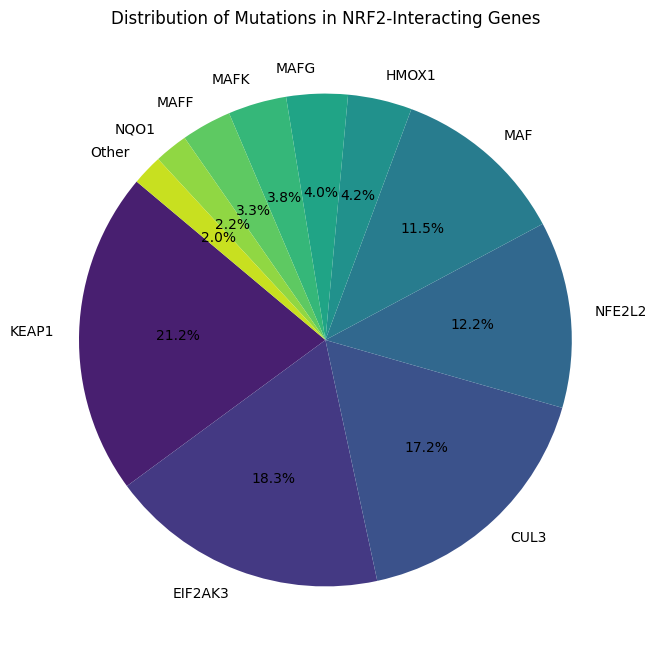

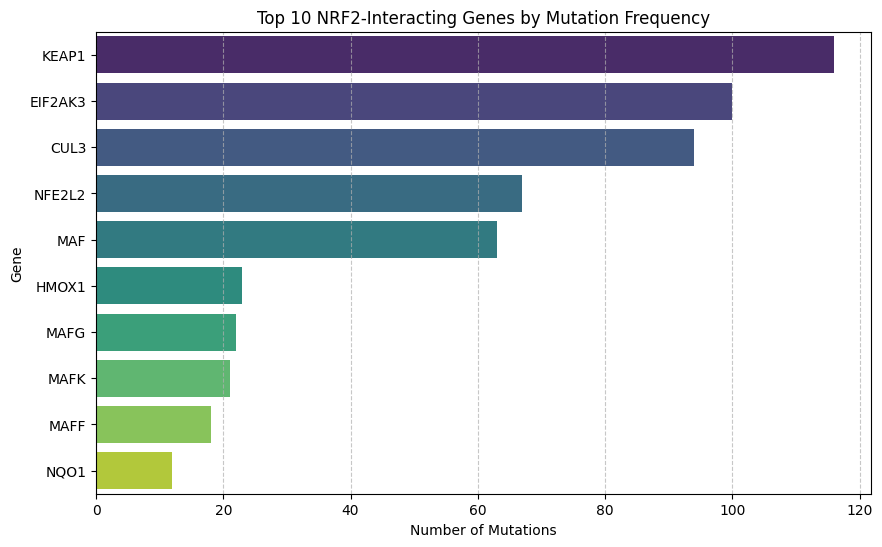

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get list of proteins
list_of_proteins = list(set(NRF2_interactions['#node1'].tolist() + NRF2_interactions['node2'].tolist()))

# Get mutation counts for NRF2-interacting genes
mutation_counts = DF[DF.Gene.isin(list_of_proteins)].Gene.value_counts()

# Define the number of top genes to display separately in the chart
top_genes = 10  # Show top 10 genes, group the rest into "Other"
mutation_counts_top = mutation_counts[:top_genes]
other_mutations = mutation_counts[top_genes:].sum()

# Create labels and sizes for pie chart
labels = list(mutation_counts_top.index) + ["Other"]
sizes = list(mutation_counts_top.values) + [other_mutations]

# Plot Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, 
        colors=sns.color_palette("viridis", len(labels)))
plt.title("Distribution of Mutations in NRF2-Interacting Genes")
plt.show()

# 🎨 Visualization: Bar Chart of Mutation Distribution in NRF2-Interacting Genes
plt.figure(figsize=(10, 6))
sns.barplot(y=mutation_counts_top.index, x=mutation_counts_top.values, palette="viridis")
plt.xlabel("Number of Mutations")
plt.ylabel("Gene")
plt.title("Top 10 NRF2-Interacting Genes by Mutation Frequency")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


## 📌 **Exercise: Investigating the Role of KEAP1, EIF2AK3, and CUL3 in NRF2 Regulation**  

### 🔎 **Background**  
From the mutation analysis, we found that **KEAP1, EIF2AK3, and CUL3** are among the most frequently mutated NRF2-interacting proteins. Now, we want to **formulate hypotheses** about their functional roles in NRF2 regulation.  

Using **STRINGdb**, explore how these proteins interact with NRF2 and propose potential consequences if they are mutated.  

---

## 📝 **Your Tasks**  

1️⃣ **Use STRING Database** ([🔗 Visit STRINGdb](https://string-db.org/))  
   - Search for **KEAP1, EIF2AK3, and CUL3** one at a time.  
   - Look at their **interaction partners**, especially NRF2 (NFE2L2).  
   - Identify **key biological pathways** they are involved in.  

2️⃣ **Hypothesis Development**  
   - **KEAP1:**  
     - What is its role in NRF2 degradation?  
     - What happens if KEAP1 is mutated? (e.g., loss of function, altered NRF2 stability)  

   - **CUL3:**  
     - How does CUL3 interact with KEAP1?  
     - What is the role of **E3 ubiquitin ligases** in NRF2 degradation?  
     - What might happen if CUL3 mutations disrupt its function?  

   - **EIF2AK3:**  
     - This protein is involved in the **unfolded protein response (UPR)** and **cellular stress response**.  
     - How might EIF2AK3 mutations affect NRF2-driven stress responses?  

3️⃣ **Biological Impact Scenarios**  
   - If **KEAP1 is inactivated by mutation**, how might NRF2 activity change?  
   - If **CUL3 is mutated**, would KEAP1 still be able to degrade NRF2?  
   - If **EIF2AK3 is mutated**, could NRF2 compensate for its loss in stress response?  

---

## 🎯 **Deliverables**  
✔ **A short summary** of your findings based on STRINGdb interactions.  
✔ **A hypothesis** on how KEAP1, EIF2AK3, and CUL3 mutations influence NRF2 regulation.  
✔ **Possible experimental approaches** to test these hypotheses (optional).  

🚀 **Now, dive into STRINGdb and start exploring NRF2’s regulatory network!**  


In [8]:
# Make a slice of the original DF to only focus on NRF2-related proteins
NRF2_DF = DF[DF.Gene.isin(list_of_proteins)]

#View the NRF2-related genes
NRF2_DF.Gene.unique()

array(['NFE2L2', 'KEAP1', 'MAF', 'CUL3', 'PARK7', 'EIF2AK3', 'MAFK',
       'MAFF', 'HMOX1', 'NQO1', 'MAFG'], dtype=object)

## 📌 **Understanding Gene Expression & NRF2 Activity in Cancer Cell Lines**  

### 🔎 **Background: RNA Sequencing & Gene Expression**  
In modern cancer research, **RNA sequencing (RNA-seq)** allows us to measure **gene expression levels** across thousands of genes in a cell.  
- **Each gene’s RNA level** tells us how much it is being transcribed into mRNA, providing insight into its **activity** in the cell.  
- In cancer cell lines, **RNA-seq data** have been collected for **thousands of cell lines** across **24,000 genes**, allowing us to:  
  ✔ Compare which genes are **highly expressed vs. silenced**  
  ✔ Study how different **mutations impact gene expression**  

---

### 🧬 **NRF2 as a Transcriptional Regulator**  
NRF2 (**NFE2L2**) is a **master transcription factor** that regulates over **500 genes** involved in:  
✔ **Oxidative stress response**  
✔ **Detoxification**  
✔ **Metabolism & survival pathways**  

To measure **NRF2 activity** across cell lines, we use **Gene Set Enrichment Analysis (GSEA)**, which calculates a **score** for how active an entire **set of NRF2 target genes** is within each cell line.  

---

### 📂 **Loading Precomputed NRF2 Activity Scores**  
We have a precomputed dataset containing **GSEA scores** for NRF2 activity across **cancer cell lines from DepMap**.  

🔹 **What We Can Do with This Data:**  
- **Compare NRF2 activity across different cell lines**  
- **Identify cell lines with the highest NRF2 activity**  
- **Investigate whether mutations drive NRF2 hyperactivity**  


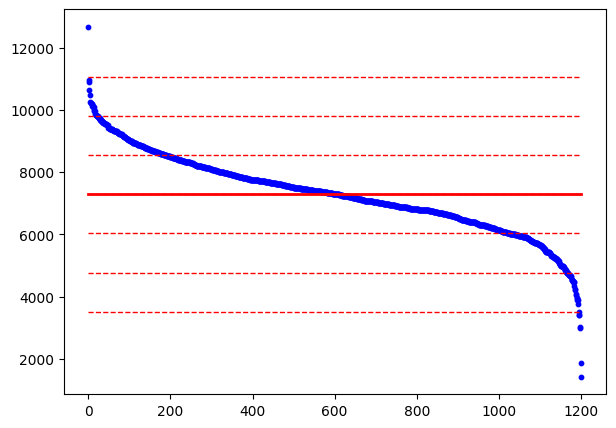

In [9]:
pathways_ds = pd.read_table('CCLE_expression_full.reformatted.NRF2_signature.gct',sep='\t', skiprows=2,index_col=0).drop('Description',1)

NRF2_sig = pathways_ds.loc['NFE2L2.V2',:].sort_values(ascending = False)
NRF2_sig_mean = NRF2_sig.mean()
NRF2_sig_std = NRF2_sig.std()

fig = plt.figure(figsize=(7, 5))
plt.plot([0, NRF2_sig.size], [NRF2_sig_mean, NRF2_sig_mean], color = 'red', lw=2, linestyle = 'solid')
for sigma in [range(-3, 3+1)]:
    plt.plot([0, NRF2_sig.size], [NRF2_sig_mean + sigma*NRF2_sig_std, NRF2_sig_mean + sigma*NRF2_sig_std], color = 'red', lw=1, linestyle = 'dashed')
plt.scatter(x = range(NRF2_sig.size), y = NRF2_sig, s = 10, c = 'blue', marker = 'o')


## 📌 **Visualizing NRF2 Activity Scores Across Cancer Cell Lines**  

### 🔎 **What This Code Does**  
We are loading **NRF2 signature scores** from RNA sequencing data across cancer cell lines.  
This helps us identify which **cell lines have high NRF2 activity** and which have low NRF2 activity.  

---

## 📂 **Step 1: Load NRF2 Signature Scores**  
The dataset is stored in a **GCT file**, a common format for expression data.  
We:

1️⃣ **Read in the dataset** using `pandas.read_table()`  
2️⃣ **Skip metadata rows** (`skiprows=2`)  
3️⃣ **Set the index** to keep track of genes (`index_col=0`)  
4️⃣ **Drop** the 'Description' column to clean up the dataset  


## 📌 **Defining "NRF2-Active" and "NRF2-Inactive" Cell Lines**  

### 🔎 **Why Set a Threshold?**  
To study how **NRF2 transcriptional activity is regulated**, we need to **classify cell lines** into:  
✔ **NRF2-Active (1)** → High NRF2 transcriptional activity  
✔ **NRF2-Inactive (0)** → Low NRF2 transcriptional activity  

A simple way to define this threshold is:  
📈 **Active (1):** NRF2 score is **above** the mean + 1 standard deviation  
📉 **Inactive (0):** NRF2 score is **below** this threshold  

---

### 📝 **Step 2: Compute the NRF2 Activation Threshold**  
We calculate:  
✔ **Mean NRF2 Signature Score**  
✔ **Standard Deviation (variability across cell lines)**  
✔ **Threshold = Mean + 1 Standard Deviation**  


0    1014
1     187
Name: NRF2_Act, dtype: int64


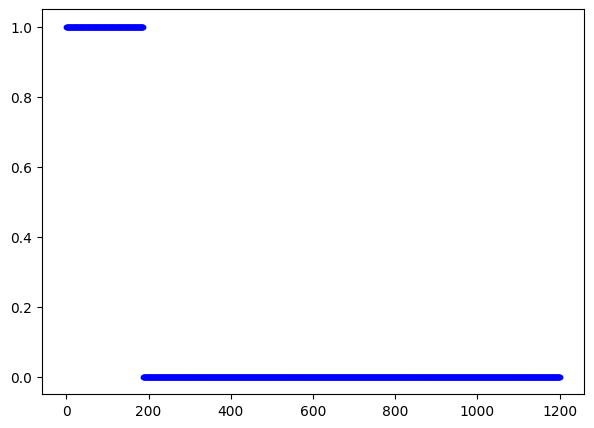

In [10]:
NRF2_Act = pd.Series(np.where(NRF2_sig >= NRF2_sig_mean + NRF2_sig_std, 1, 0), 
                     index = NRF2_sig.index, name='NRF2_Act')
print(NRF2_Act.value_counts())
fig = plt.figure(figsize=(7, 5))

plt.scatter(x = range(NRF2_Act.size), y = NRF2_Act, s = 10, c = 'blue', marker = 'o')


## 📌 **Exercise: Investigating Mutations & Disease Associations in NRF2-Active Cell Lines**  

### 🔎 **Background**  
Now that we have classified **NRF2-active (1) vs. NRF2-inactive (0) cell lines**, we want to explore:  
✔ Which **genes** are frequently mutated in NRF2-active cell lines?  
✔ Which **primary diseases** are enriched in NRF2-active cell lines?  

By comparing these distributions to **all cell lines**, we can identify potential **drivers of NRF2 activation** in cancer.  

---

## 📝 **Your Tasks**  

### 📊 **Part 1: Mutations in NRF2-Related Genes**  
1️⃣ **Filter mutations** to include only **NRF2-interacting genes** (e.g., KEAP1, CUL3, EIF2AK3).  
2️⃣ **Compare the mutation frequencies** in NRF2-active cell lines vs. all cell lines.  
3️⃣ **Create a pie chart** showing the **proportion of mutations per gene** in NRF2-active vs. all cell lines.  
4️⃣ **Interpret your findings:**  
   - Are certain NRF2-related genes more frequently mutated in **NRF2-active cell lines**?  
   - Do these mutations explain **why NRF2 is hyperactive**?  



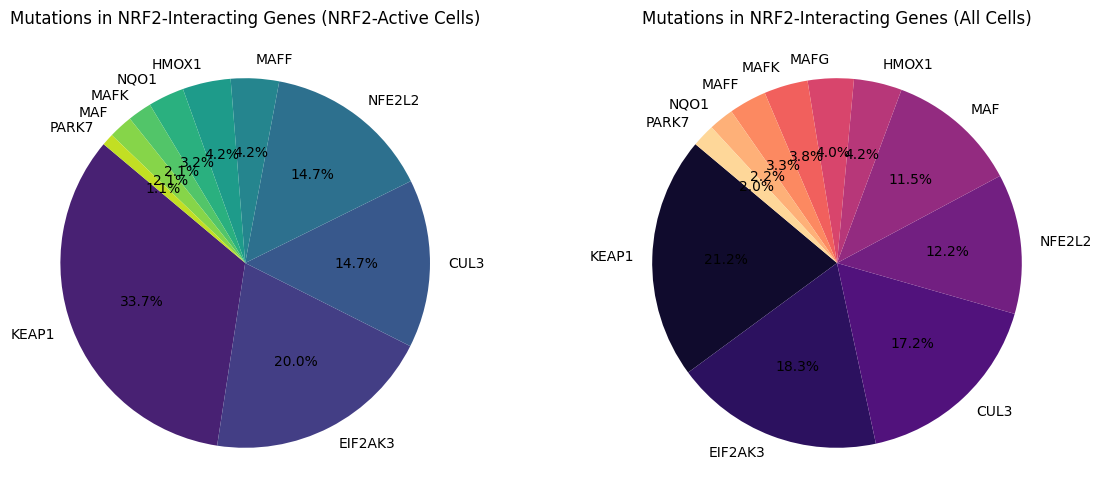

In [11]:
# 🎯 Filter dataset for NRF2-active cell lines
nrf2_active_cells = DF[DF["CCLE_Name"].isin(NRF2_Act[NRF2_Act == 1].index)]

# 🎯 Count mutations in NRF2-related genes
mutation_counts_active = nrf2_active_cells[nrf2_active_cells["Gene"].isin(list_of_proteins)]["Gene"].value_counts()
mutation_counts_all = DF[DF["Gene"].isin(list_of_proteins)]["Gene"].value_counts()

# 🎨 Pie Chart: Mutation Distribution in NRF2-Active vs. All Cell Lines
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# NRF2-Active Cell Line Mutations
ax[0].pie(mutation_counts_active, labels=mutation_counts_active.index, autopct='%1.1f%%', startangle=140, 
          colors=sns.color_palette("viridis", len(mutation_counts_active)))
ax[0].set_title("Mutations in NRF2-Interacting Genes (NRF2-Active Cells)")

# All Cell Line Mutations
ax[1].pie(mutation_counts_all, labels=mutation_counts_all.index, autopct='%1.1f%%', startangle=140, 
          colors=sns.color_palette("magma", len(mutation_counts_all)))
ax[1].set_title("Mutations in NRF2-Interacting Genes (All Cells)")

plt.show()

In [12]:
# Recall that you can get primary disease information in the following way: 

NRF2_DF[NRF2_DF.CCLE_Name.isin(NRF2_Act[NRF2_Act==1].index.tolist())].Gene.value_counts()

KEAP1      32
EIF2AK3    19
CUL3       14
NFE2L2     14
MAFF        4
HMOX1       4
NQO1        3
MAFK        2
MAF         2
PARK7       1
Name: Gene, dtype: int64

Let's make a new dataframe that is a slice of the NRF2_DF that focuses on the NRF2 active cell lines and on variants that are missense mutations

In [15]:
NRF2_DF_act = NRF2_DF[(NRF2_DF.CCLE_Name.isin(NRF2_Act[NRF2_Act==1].index.tolist()))&(NRF2_DF.Variant_Classification=='Missense_Mutation')]

## 📌 **Exploring KEAP1 Mutations in NRF2-Active Cell Lines**  

### 🔎 **Why Focus on KEAP1?**  
KEAP1 is a **negative regulator of NRF2**, meaning it **binds to NRF2 and targets it for degradation** under normal conditions.  
Mutations in KEAP1 can **disrupt its function**, leading to **NRF2 hyperactivation** and cancer progression.  

✔ **If KEAP1 is mutated, NRF2 is not degraded**, leading to **persistent activation** of NRF2 target genes.  
✔ **KEAP1 mutations are the most frequent** among NRF2-interacting proteins.  

### 🎯 **Goal**  
We want to **identify KEAP1 mutations** in **NRF2-active cell lines** and explore:  
✔ Where they occur on the **KEAP1 protein structure**  
✔ How they **impact KEAP1 function**  
✔ Whether these mutations **correlate with high NRF2 activity**  

---

## 📂 **Step 1: Identify KEAP1 Mutations in NRF2-Active Cell Lines**  
We filter our dataset to include:  
✔ **Only NRF2-active cell lines**  
✔ **Only mutations in KEAP1**  


## 🔬 **Visualizing KEAP1 Binding to NRF2 in Jupyter Lab**  

We can use Jupyter Lab to **visualize protein crystal structures** directly within our notebook. Here, we have selected a **crystal structure of KEAP1** bound to a **NRF2-like peptide**. This structure allows us to **identify the exact region of KEAP1 that interacts with NRF2**, providing insight into how KEAP1 regulates NRF2 activity. By mapping mutations onto this structure, we can explore how genetic alterations may disrupt KEAP1’s function and lead to increased NRF2 activation.


In [13]:
KEAP1 = py3Dmol.view(query='pdb:3WN7') 

KEAP1.setStyle({'chain':['A']},{'cartoon': {'color': 'yellow'}}) 
KEAP1.addLabel('KEAP1', {'fontColor':'yellow', 'backgroundColor':'lightgray'}, {'chain': ['A']}) # adding a label                                              
KEAP1.setStyle({'chain':['B']},{'cartoon': {'color': 'blue'}}) # beta subunits of hemoglobin
KEAP1.addLabel('NRF2', {'fontColor':'blue', 'backgroundColor':'lightgray'}, {'chain': ['B']}) #adding a label

KEAP1.setStyle({'chain':['L']},{'cartoon': {'color': 'yellow'}}) 
KEAP1.addLabel('KEAP1', {'fontColor':'yellow', 'backgroundColor':'lightgray'}, {'chain': ['L']}) # adding a label                                              
KEAP1.setStyle({'chain':['M']},{'cartoon': {'color': 'blue'}}) # beta subunits of hemoglobin
KEAP1.addLabel('NRF2', {'fontColor':'blue', 'backgroundColor':'lightgray'}, {'chain': ['M']}) #adding a label

KEAP1.zoomTo() # this command makes sure the output zooms in on the protein
KEAP1.show() # this command shows us the protein

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Map Mutated Residues to PDB

We can select a slice of NRF2_DF_act that tells us all mutations in KEAP1: 

In [16]:
NRF2_DF_act[(NRF2_DF_act.Gene=='KEAP1')].Protein_Change.unique()

array(['p.I137T', 'p.A203V', 'p.G523W', 'p.R272L', 'p.N414Y', 'p.G462W',
       'p.E307Q', 'p.P322L', 'p.A556T', 'p.G333C', 'p.G603V', 'p.M67V',
       'p.R320L', 'p.G364C', 'p.W252C', 'p.G430V', 'p.G430C', 'p.M283L',
       'p.M133I', 'p.R326C', 'p.R614Q', 'p.D538N', 'p.G367S', 'p.V302A'],
      dtype=object)

Here is a visualization code that take these mutations and labels them on the KEAP1 protein for easy viewing:

In [17]:
import py3Dmol
import re

def visualize_protein_mutations(pdb_id, gene_name, df):
    """
    Visualizes missense mutations for a given gene in a specific PDB structure.
    
    Parameters:
    - pdb_id (str): PDB ID of the protein structure to visualize.
    - gene_name (str): The gene for which mutations will be visualized.
    - df (DataFrame): DataFrame containing mutation information.
    
    Example Usage:
    visualize_protein_mutations("3WN7", "KEAP1", NRF2_DF)
    """

    # Load the PDB structure
    viewer = py3Dmol.view(query=f'pdb:{pdb_id}', width=800, height=600)

    # Color the entire protein structure
    viewer.setStyle({'cartoon': {'color': 'lightgray'}})

    # Define chains for KEAP1 and NRF2 visualization --> this is PDB dependent!
    chains = {'KEAP1': ['A', 'L'], 'NRF2': ['B', 'M']}

    # Assign colors to each chain --> this is PDB dependent!
    chain_colors = {'KEAP1': 'yellow', 'NRF2': 'blue'}

    # Add labels and styles for KEAP1 and NRF2 chains
    for protein, chain_ids in chains.items():
        for chain_id in chain_ids:
            viewer.setStyle({'chain': chain_id}, {'cartoon': {'color': chain_colors[protein]}})
            viewer.addLabel(protein, {'fontColor': chain_colors[protein], 'backgroundColor': 'lightgray'}, {'chain': chain_id})

    # Filter for missense mutations in the specified gene
    gene_mutations = df[(df.Gene == gene_name) & (df.Variant_Classification == 'Missense_Mutation')]

    # Extract residue numbers
    residue_nums = []
    for mutation in gene_mutations.Protein_Change.unique():
        try:
            num = re.findall(r'\d+', str(mutation).split('.')[1])[0]  # Extract residue number
            residue_nums.append(num)
        except IndexError:
            continue  # Skip if mutation format is unexpected

    # Highlight mutated residues in red and add labels
    for res in residue_nums:
        viewer.setStyle({'chain': 'A', 'resi': res}, {'stick': {'colorscheme': 'redCarbon'}})
        viewer.addLabel(f"{res}", {'fontColor': 'red', 'backgroundColor': 'lightgray'}, {'chain': 'A', 'resi': res})

    # Zoom and display the protein
    viewer.zoomTo()
    return viewer.show()

# Example Usage
#visualize_protein_mutations("3WN7", "KEAP1", NRF2_DF)


In [18]:
visualize_protein_mutations("3WN7", "KEAP1", NRF2_DF_act[(NRF2_DF_act.Gene=='KEAP1')])

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## 📌 Assignment: Investigating KEAP1 Mutations and Their Impact on NRF2 Activity  

### 🔎 Background  
Now that you have analyzed **KEAP1 mutations in NRF2-activated cell lines**, consider why this association exists.  

KEAP1 normally **targets NRF2 for degradation**, preventing excessive NRF2 activity. However, specific **mutations in KEAP1** may disrupt this process, leading to **increased NRF2 activity** and altered cellular metabolism.  

---

## **📝 Your Tasks**  

### **🔬 Part 1: Generate a Hypothesis**  
1️⃣ Based on the **location of KEAP1 mutations**, propose a hypothesis:  
   - What might be special about the region where these mutations cluster? How does this compare to mutations in non NRF2-active cell lines?   
   - How could these mutations **disrupt KEAP1’s ability to regulate NRF2**? (e.g. steric, polarity, charge changes?)

2️⃣ **Write a short explanation** describing your hypothesis before proceeding. How do these changes impact NRF2 binding, and ultimately its ability to regulate transcription of over 500 target genes? 



## 📌 Assignment: Investigating Mutations in Other NRF2-Interacting Proteins  

### 🔎 Background  
In the previous assignment, you explored how **KEAP1 mutations affect NRF2 activity**. However, NRF2 function is regulated by a **network of interacting proteins**, including **CUL3**, an E3 ligase that forms a complex with KEAP1 to degrade NRF2.  

In this assignment, you will:  
✔ **Select two NRF2-related proteins (one will be CUL3, PDB: 3HQI)**  
✔ **Analyze where mutations occur on these proteins**  
✔ **Form hypotheses about how these mutations may disrupt NRF2 function**  

---

## **📝 Your Tasks**  

### **🔬 Part 1: Select Two NRF2-Interacting Proteins**  
1️⃣ One of your proteins must be **CUL3 (PDB: 3HQI)**.  
2️⃣ Choose a second protein from known NRF2 regulators (e.g., **NFE2L2, EIKF2A3, SRXN1, GSK3B, BACH1, MAFG**).  
3️⃣ Retrieve **mutation data** for both proteins from the dataset and re-create this analysis.  



---

If you are curious to learn more about how mutations impact transcriptional activities, have a look at our paper: 

https://pubs.acs.org/doi/abs/10.1021/acs.jcim.3c01967